<a href="https://colab.research.google.com/github/Yanlecun/intro_ml_notebooks/blob/main/MLFlow_%ED%85%8C%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/Mlflow")

In [ ]:
# 캐글
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 92% 61.0M/66.0M [00:00<00:00, 76.6MB/s]
100% 66.0M/66.0M [00:00<00:00, 134MB/s] 


In [ ]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"mlflow: {mlflow.__version__}")

numpy: 1.21.5
pandas: 1.3.5
matplotlib: 3.2.2
seaborn: 0.11.2
sklearn: 1.0.2
mlflow: 1.24.0


In [ ]:
data_path = "./creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)

In [ ]:
normal = df[df.Class==0].sample(frac=0.5, random_state = 100).reset_index(drop=True)
anomaly = df[df.Class==1]

In [ ]:
# train - test 데이터셋 분리
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state= 100)
anomaly_train, anomaly_test = train_test_split(anomaly,test_size = 0.2, random_state= 100)

# 80%의 train set내에서 20%차지하도록 25% validation set 으로 분리
normal_train, normal_val = train_test_split(normal_train, test_size = 0.25, random_state = 100)
anomaly_train, anomaly_val = train_test_split(anomaly_train, test_size = 0.25, random_state = 100)

In [ ]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_val = pd.concat((normal_val, anomaly_val))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_val = np.array(x_val["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_val = x_val.drop("Class", axis=1)

print(f'train dataset : {x_train.shape}, {y_train.shape}')
print(f'test dataset : {x_test.shape}, {y_test.shape}')
print(f'validation dataset : {x_val.shape}, {y_val.shape}')

train dataset : (85588, 29), (85588,)
test dataset : (28531, 29), (28531,)
validation dataset : (28531, 29), (28531,)


In [ ]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class",axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

train dataset : (85588, 29), (85588,)
test dataset : (28531, 29), (28531,)
validation dataset : (28531, 29), (28531,)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


#  MLFlow를 이용한 모델 학습 및 평가


## 학습 및 학습 정확도 지표

In [ ]:
def train(sk_model, x_train, y_train) :
  sk_model = sk_model.fit(x_train, y_train)
  train_acc = sk_model.score(x_train, y_train)
  mlflow.log_metric("train_acc", train_acc)
  print(f"Train Accuracy: {train_acc:.3%}")

학습이 진행되며, 학습정확도 지표는 mlflow에 로깅된다.

In [ ]:
def evaluate(sk_model, x_test, y_test) :
  eval_acc = sk_model.score(x_test, y_test)
  preds= sk_model.predict(x_test)
  auc_score = roc_auc_score(y_test, preds)
  mlflow.log_metric("eval_acc", eval_acc)
  mlflow.log_metric("auc_score", auc_score)
  print(f"Evaluate Accuracy: {auc_score:.3%}")
  print(f"Accuracy Accuracy: {eval_acc:.3%}")
  roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='scikit_learn ROC Curve')
  plt.savefig("sklearn_roc_plot.png")
  plt.show()
  plt.clf()
  conf_matrix = confusion_matrix(y_test, preds)
  ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.savefig("sklearn_conf_matrix.png")
  mlflow.log_artifact("sklearn_roc_plot.png")
  mlflow.log_artifact("sklearn_conf_matrix.png")


평가지표 및 Confusion Matrix, ROC 곡선에 대한 그림이 생성되며, 그래프와 지표 모두 MLFlow에 로깅된다.

##  MLFlow 실행 로깅 및 확인

실제로 실행시켜보자

Train Accuracy: 99.880%
Evaluate Accuracy: 88.372%
Accuracy Accuracy: 99.895%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


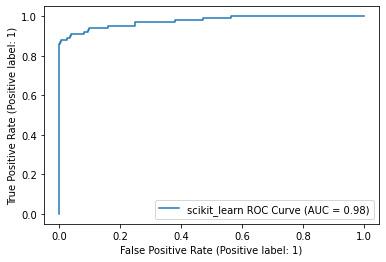

model run :  de250c23c7f5420991c7da56bacbdf0e


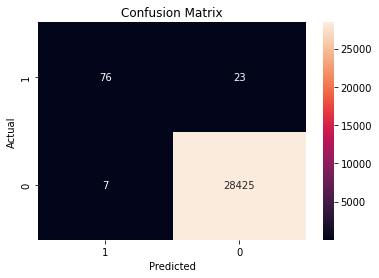

In [ ]:
sk_model = LogisticRegression(max_iter = 400, solver='newton-cg')
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/Mlflow") # expriment 설정, 없는 경우 새로 생성
with mlflow.start_run():  # expreiment 생성하면서 실행되는 코드
  train(sk_model, x_train, y_train)
  evaluate(sk_model, x_test, y_test)
  mlflow.sklearn.log_model(sk_model, "log_Reg_model") # 모델 로깅 시에 사용되는 일반적인 규칙이며 저장되는 모델과 모델 명을 설정한다.
  print("model run : ", mlflow.active_run().info.run_uuid)
mlflow.end_run() 

https://community.cloud.databricks.com/ 에 접속해서 확인하면 지표와 이미지를 확인할 수 있다.